<h2>Import libraries</h2>

In [1]:
import sys
from pathlib import Path
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import os
from PIL import Image
import cv2
from sklearn.utils import shuffle
sys.path.append(str(Path.cwd().parent))
from src.make_dataset import load_data
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array

# Utiliser tensorflow.keras au lieu de keras directement
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from src.trainer import ImageTrainer
import mlflow
import mlflow.sklearn
import logging
from datetime import datetime
from src.utils import plot_confusion_matrix
from src.utils import datagen


<h2>Settings</h2>

In [2]:
project_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(project_dir, 'data', 'Garbage_classification','Garbage_classification')
logger.info(f"\nProject directory: {project_dir} \nData directory: {data_path}")

# Configure logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

2024-08-06 23:12:23.777 | INFO     | __main__:<cell line: 3>:3 - 
Project directory: c:\Users\ass_s\OneDrive\Documenti\Garbage_Classification 
Data directory: c:\Users\ass_s\OneDrive\Documenti\Garbage_Classification\data\Garbage_classification\Garbage_classification


<h2>Data Collection</h2>

In [3]:
images, labels = load_data(True)
# Afficher le nombre d'images et de labels chargés
print(f'Nombre d\'images chargées: {len(images)}')
print(f'Nombre de labels chargés: {len(labels)}')

2024-08-06 23:12:39.118 | INFO     | src.make_dataset:load_data:74 - Dataset lo load: asdasdasasdas/garbage-classification
2024-08-06 23:12:39.119 | INFO     | src.make_dataset:load_data:75 - Data shape: Images: 2527, Labels: 2527


Nombre d'images chargées: 2527
Nombre de labels chargés: 2527


<h2>EDA: Exploratory Data Analysis</h2>

In [4]:
labels[2500]

'metal'

In [5]:
images[2500]

array([[[189, 196, 245],
        [189, 196, 245],
        [189, 196, 245],
        ...,
        [163, 179, 246],
        [163, 179, 246],
        [163, 179, 246]],

       [[189, 196, 245],
        [189, 196, 245],
        [189, 196, 245],
        ...,
        [163, 179, 246],
        [163, 179, 246],
        [163, 179, 246]],

       [[189, 196, 245],
        [189, 196, 245],
        [189, 196, 245],
        ...,
        [163, 179, 246],
        [163, 179, 246],
        [163, 179, 246]],

       ...,

       [[196, 181, 165],
        [196, 181, 165],
        [196, 181, 165],
        ...,
        [165, 156, 143],
        [165, 156, 143],
        [165, 156, 143]],

       [[196, 181, 165],
        [196, 181, 165],
        [196, 181, 165],
        ...,
        [165, 156, 143],
        [165, 156, 143],
        [165, 156, 143]],

       [[196, 181, 165],
        [196, 181, 165],
        [196, 181, 165],
        ...,
        [165, 156, 143],
        [165, 156, 143],
        [165, 156, 143]]

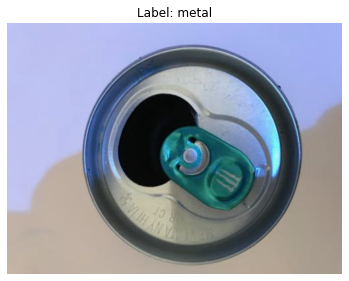

In [6]:
# Afficher l'image avec son label
plt.figure(figsize=(6, 6))
plt.imshow(images[2500])
plt.title(f"Label: {labels[2500]}")
plt.axis('off')
plt.show()

In [7]:
# List categories
categories = os.listdir(data_path)
print("Categories:", categories)

Categories: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


           Count
cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137


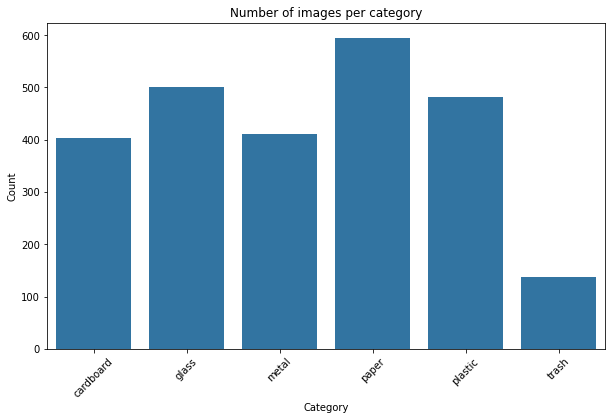

In [8]:
# Count the number of images in each category
category_counts = {category: len(os.listdir(os.path.join(data_path, category))) for category in categories}
category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])
print(category_counts_df)

# Plot the number of images per category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts_df.index, y=category_counts_df['Count'])
plt.title('Number of images per category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

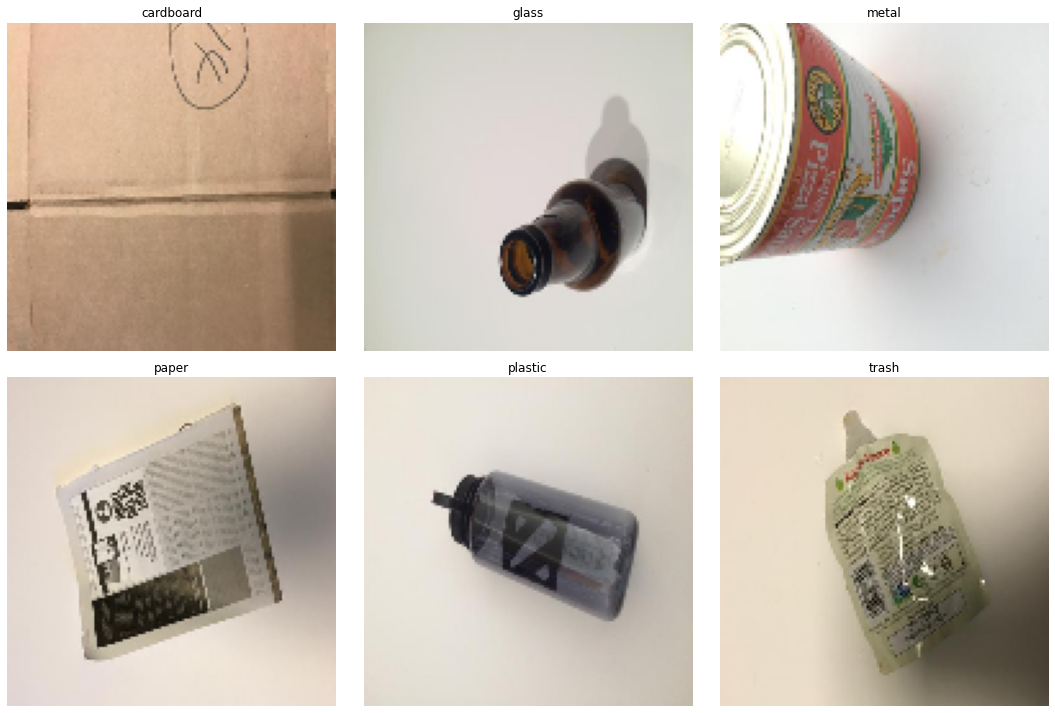

In [9]:
# Cell 4: Visualize some images from each category
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    img_path = os.path.join(data_path, category, os.listdir(os.path.join(data_path, category))[0])
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Initialize a list to store image dimensions
image_dimensions = []

# Iterate over each category and each image within the category
for category in categories:
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        with Image.open(img_path) as img:
            image_dimensions.append(img.size)  # img.size returns (width, height)

# Convert the list of dimensions to a DataFrame for better analysis
image_dimensions_df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

# Check if all dimensions are the same
unique_dimensions = image_dimensions_df.drop_duplicates()
if len(unique_dimensions) == 1:
    print(f"All images have the same size: {unique_dimensions.iloc[0].to_dict()}")
else:
    print("Not all images have the same size.")
    print("Different image sizes found:")
    print(unique_dimensions)


All images have the same size: {'Width': 512, 'Height': 384}


<h1>Modeling</h1>

In [11]:
def create_cnn_model(input_shape=(128, 128, 3), num_classes=6):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
cnn_model = create_cnn_model(input_shape=(128, 128, 3), num_classes=6)

In [13]:
# Créer une instance de ImageTrainer avec les images, labels et le modèle
trainer = ImageTrainer(data=images, labels=labels, model=cnn_model)

# Entraîner le modèle et évaluer les métriques
train_metrics, val_metrics, test_metrics, sk_model = trainer.train()
# Plot confusion matrix
plot_confusion_matrix(train_metrics["confusion_matrix"], "Confusion Matrix (Train)")
plot_confusion_matrix(test_metrics["confusion_matrix"], "Confusion Matrix (Test)")


Epoch 1/20



55/55 [==============================] - 34s 575ms/step - loss: 1.6401 - accuracy: 0.3243 - val_loss: 1.4965 - val_accuracy: 0.4292
Epoch 2/20
55/55 [==============================] - 30s 526ms/step - loss: 1.4628 - accuracy: 0.4136 - val_loss: 1.3955 - val_accuracy: 0.4104
Epoch 3/20
27/55 [=============>................] - ETA: 14s - loss: 1.2953 - accuracy: 0.4792

KeyboardInterrupt: 

<h2>Tester d'autres modéles</h2>

In [14]:
def create_resnet_model(input_shape=(128, 128, 3), num_classes=6):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_vgg19_model(input_shape=(128, 128, 3), num_classes=6):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_inception_model(input_shape=(128, 128, 3), num_classes=6):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Define models and parameters to benchmark
ESTIMATOR_PARAMS = {
    "VGG16": {"estimator": create_vgg19_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},
    "InceptionV3": {"estimator": create_inception_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},
    "CNN": {"estimator": create_cnn_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},
}

In [16]:
# Create an experiment if not exists
exp_name = "image-classification"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id

logger.info(f"Experiment id: {experiment_id}")

INFO:__main__:Experiment id: 303343463541140829


In [17]:
input_shape = (128, 128, 3)  # Assuming your images have 3 color channels (RGB)
num_classes = len(np.unique(labels))

# Loop through the models and their configurations
for model_name, model_configs in ESTIMATOR_PARAMS.items():
    logger.info(f"{model_name} \n{model_configs}")

    estimator = model_configs["estimator"]
    params = model_configs["params"]

    # Initialiser le modèle Keras directement
    model = estimator(**params)
    
    # Initialize and use the ImageTrainer with the current model and data augmentation
    trainer = ImageTrainer(data=images, labels=labels, model=model)
    train_metrics, val_metrics, test_metrics, trained_model = trainer.train()
    
    # Convert confusion matrix to DataFrame
    class_names = list(trainer.label_mapping.keys())  # Get class names from label mapping
    train_conf_matrix_df = pd.DataFrame(train_metrics["confusion_matrix"], index=class_names, columns=class_names)
    val_conf_matrix_df = pd.DataFrame(val_metrics["confusion_matrix"], index=class_names, columns=class_names)
    test_conf_matrix_df = pd.DataFrame(test_metrics["confusion_matrix"], index=class_names, columns=class_names)

    # Start MLflow run
    run_name = f"{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        # Log parameters
        mlflow.log_params({
            "model_name": model_name,
            "target_size": trainer.target_size,
            "batch_size": trainer.batch_size,
            "epochs": trainer.epochs,
            "test_size": trainer.test_size,
            "random_state": trainer.random_state
        })

        # Log metrics
        mlflow.log_metrics({
            "train_accuracy": train_metrics["accuracy"],
            "val_accuracy": val_metrics["accuracy"],
            "test_accuracy": test_metrics["accuracy"]
        })
        # Log classification report as CSV
        train_metrics["classification_report"].to_csv("train_classification_report.csv")
        val_metrics["classification_report"].to_csv("val_classification_report.csv")
        test_metrics["classification_report"].to_csv("test_classification_report.csv")
        mlflow.log_artifact("train_classification_report.csv")
        mlflow.log_artifact("val_classification_report.csv")
        mlflow.log_artifact("test_classification_report.csv")

        # Log confusion matrix as CSV
        train_conf_matrix_df.to_csv("train_confusion_matrix.csv")
        val_conf_matrix_df.to_csv("val_confusion_matrix.csv")
        test_conf_matrix_df.to_csv("test_confusion_matrix.csv")
        mlflow.log_artifact("train_confusion_matrix.csv")
        mlflow.log_artifact("val_confusion_matrix.csv")
        mlflow.log_artifact("test_confusion_matrix.csv")

        # Log model
        #mlflow.keras.log_model(trained_model, artifact_path=f"model_{model_name}")

INFO:__main__:VGG16 
{'estimator': <function create_vgg19_model at 0x00000255CCE33910>, 'params': {'input_shape': (128, 128, 3), 'num_classes': 6}}


Epoch 1/20
55/55 [==============================] - 229s 4s/step - loss: 1.4792 - accuracy: 0.3882 - val_loss: 1.1531 - val_accuracy: 0.5813
Epoch 2/20
55/55 [==============================] - 232s 4s/step - loss: 1.2181 - accuracy: 0.5265 - val_loss: 1.1063 - val_accuracy: 0.5813
Epoch 3/20
55/55 [==============================] - 212s 4s/step - loss: 1.1132 - accuracy: 0.5628 - val_loss: 1.0477 - val_accuracy: 0.6083
Epoch 4/20
55/55 [==============================] - 241s 4s/step - loss: 1.0470 - accuracy: 0.5835 - val_loss: 0.9433 - val_accuracy: 0.6396
Epoch 5/20
55/55 [==============================] - 244s 4s/step - loss: 0.9870 - accuracy: 0.6273 - val_loss: 0.8500 - val_accuracy: 0.7125
Epoch 6/20
34/55 [=================>............] - ETA: 1:13 - loss: 0.9790 - accuracy: 0.6118

In [ ]:
"ResNet50": {"estimator": create_resnet_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},